In [2]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import aesara.tensor.subtensor as st
from itertools import combinations


%load_ext lab_black
%load_ext watermark

# Simvastatin

This one is about factorial designs (2-way ANOVA) with sum-to-zero and corner constraints.

Adapted from [unit 7: simvastatin.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit7/simvastatin.odc).

Data can be found [here](https://raw.githubusercontent.com/areding/6420-pymc/main/data/simvastatin_data.txt).


## Associated lecture videos 
### Unit 8 Lesson 8

In [5]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed?v=xomK4tcePmc&list=PLv0FeK5oXK4l-RdT6DWJj0_upJOG2WKNO&index=70" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>

### Unit 7 Lesson 9

In [2]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed?v=xomK4tcePmc&list=PLv0FeK5oXK4l-RdT6DWJj0_upJOG2WKNO&index=71" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>

## Problem statement
In a quantitative physiology lab II at Georgia Tech, students were asked to find a therapeutic model to test on MC3T3-E1 cell line to enhance osteoblastic growth. The students found a drug called Simvastatin, a cholesterol lowering drug to test on these cells. Using a control and three different concentrations: 10^-9, 10*-8 and 10-7 M, cells were treated with the drug. These cells were plated on four, 24 well plates with each well plate having a different treatment. To test for osteoblastic differentiation an assay, pNPP, was used to test for alkaline phosphatase activity. The higher the alkaline phosphatase activity the better the cells are differentiating, and become more bone like. This assay was performed 6 times total within 11 days. Each time the assay was performed, four wells from each plate were used.

notes: 

love this explanation of stz constraints:
https://stats.stackexchange.com/questions/257778/sum-to-zero-constraint-in-one-way-anova

In [3]:
data = pd.read_csv("../data/simvastatin_data.tsv", sep="\t")

In [4]:
data

,apa,conc,time
0,0.062,1,1
1,0.517,1,1
2,0.261,1,1
3,0.154,1,1
4,0.071,2,1
...,...,...,...
91,0.085,3,6
92,0.290,4,6
93,0.090,4,6
94,0.518,4,6


In [5]:
y = data["apa"].to_numpy()

In [6]:
# set up alternate coordinates, the ID3 or clusters column
conc_idx, conc = pd.factorize(data["conc"])
time_idx, time = pd.factorize(data["time"])
coords = {"conc": conc, "id": data.index.to_numpy(), "time": time}

In [7]:
coords

{'conc': Int64Index([1, 2, 3, 4], dtype='int64'),
 'id': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]),
 'time': Int64Index([1, 2, 3, 4, 5, 6], dtype='int64')}

In [8]:
conc_idx, conc

(array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1,
        1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2,
        3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0,
        0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1,
        2, 2, 2, 2, 3, 3, 3, 3]),
 Int64Index([1, 2, 3, 4], dtype='int64'))

In [12]:
time_idx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5])

## Model 1 with sum-to-zero constraints

stuff to talk about:
- why use stz constraints
- why set pm.Deterministic on later variables
- meaning of _ and use in az.summary
- dims and how they work
- why st.set_subtensor
- brief overview of indexing
- model speed and problem diagnosis

In [86]:
alpha_combos = list(combinations(range(len(conc)), 2))
beta_combos = list(combinations(range(len(time)), 2))

In [87]:
with pm.Model(coords=coords) as m:
    apa_data = pm.Data("apa_data", y, mutable=False)
    time_idx_data = pm.Data("time_idx_data", time_idx, dims="id", mutable=False)
    conc_idx_data = pm.Data("conc_idx_data", conc_idx, dims="id", mutable=False)

    mu0 = pm.Normal("mu0", 0, tau=0.0001)
    _alpha = pm.Normal("_alpha", 0, tau=0.0001, dims="conc")
    _beta = pm.Normal("_beta", 0, tau=0.0001, dims="time")
    _alphabeta = pm.Normal("_alphabeta", 0, tau=0.0001, dims=("conc", "time"))
    tau = pm.Gamma("tau", 0.001, 0.001)
    sigma = pm.Deterministic("sigma", 1 / tau**0.5)

    # sum-to-zero constraints
    alpha = pm.Deterministic(
        "alpha",
        st.set_subtensor(_alpha[0], -_alpha[1:].sum(axis=0)),
    )
    beta = pm.Deterministic(
        "beta",
        st.set_subtensor(_beta[0], -_beta[1:].sum(axis=0)),
    )
    _alphabeta = st.set_subtensor(_alphabeta[:, 0], -_alphabeta[:, 1:].sum(axis=1))
    alphabeta = pm.Deterministic(
        "alphabeta", st.set_subtensor(_alphabeta[0, :], -_alphabeta[1:, :].sum(axis=0))
    )

    mu = (
        mu0
        + alpha[conc_idx_data]
        + beta[time_idx_data]
        + alphabeta[conc_idx_data, time_idx_data]
    )
    pm.Normal("apa", mu, tau=tau, observed=apa_data)

    [
        pm.Deterministic(f"alpha{i} - alpha{j}", alpha[i] - alpha[j])
        for i, j in alpha_combos
    ]
    [pm.Deterministic(f"beta{i} - beta{j}", beta[i] - beta[j]) for i, j in alpha_combos]

    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu0, _alpha, _beta, _alphabeta, tau]
INFO:pymc:NUTS: [mu0, _alpha, _beta, _alphabeta, tau]


/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.


In [88]:
az.summary(trace, var_names="~_", filter_vars="like", kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu0,0.239,0.025,0.191,0.287
tau,17.123,2.834,11.786,22.367
sigma,0.244,0.020,0.207,0.282
alpha[0],0.049,0.043,-0.030,0.131
alpha[1],0.068,0.043,-0.011,0.148
alpha[2],-0.075,0.043,-0.157,0.004
alpha[3],-0.042,0.043,-0.120,0.042
beta[0],0.046,0.056,-0.058,0.150
beta[1],-0.149,0.057,-0.256,-0.042
beta[2],-0.019,0.056,-0.126,0.086


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

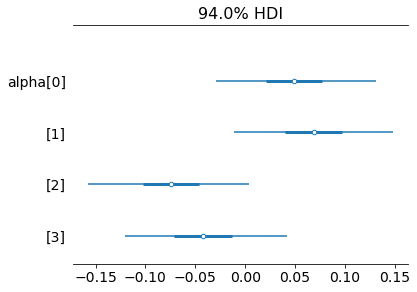

In [90]:
az.plot_forest(trace, var_names=["alpha"], combined=True)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

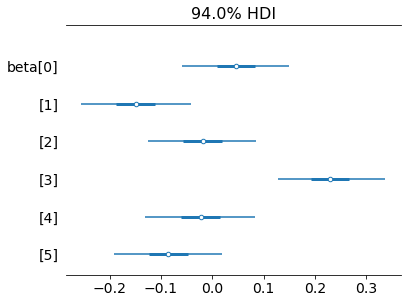

In [91]:
az.plot_forest(trace, var_names=["beta"], combined=True)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

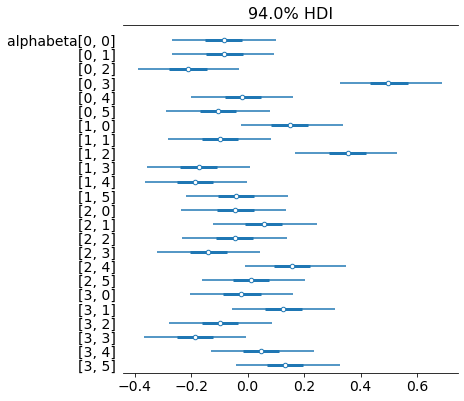

In [92]:
az.plot_forest(trace, var_names=["alphabeta"], combined=True)

## Model 2 with corner constraints

stuff to talk about:
- why corner constraints

In [9]:
with pm.Model(coords=coords) as m:
    apa_data = pm.Data("apa_data", y, mutable=False)
    time_idx_data = pm.Data("time_idx_data", time_idx, dims="id", mutable=False)
    conc_idx_data = pm.Data("conc_idx_data", conc_idx, dims="id", mutable=False)

    mu0 = pm.Normal("mu0", 0, tau=0.0001)
    _alpha = pm.Normal("_alpha", 0, tau=0.0001, dims="conc")
    _beta = pm.Normal("_beta", 0, tau=0.0001, dims="time")
    _alphabeta = pm.Normal("_alphabeta", 0, tau=0.0001, dims=("conc", "time"))
    tau = pm.Gamma("tau", 0.001, 0.001)
    sigma = pm.Deterministic("sigma", 1 / tau**0.5)

    # corner constraints
    alpha = pm.Deterministic("alpha", st.set_subtensor(_alpha[0], 0))
    beta = pm.Deterministic("beta", st.set_subtensor(_beta[0], 0))
    _alphabeta = st.set_subtensor(_alphabeta[:, 0], 0)
    alphabeta = pm.Deterministic("alphabeta", st.set_subtensor(_alphabeta[0, :], 0))

    mu = (
        mu0
        + alpha[conc_idx_data]
        + beta[time_idx_data]
        + alphabeta[conc_idx_data, time_idx_data]
    )
    pm.Normal("apa", mu, tau=tau, observed=apa_data)

    [
        pm.Deterministic(f"alpha{i} - alpha{j}", alpha[i] - alpha[j])
        for i, j in alpha_combos
    ]
    [pm.Deterministic(f"beta{i} - beta{j}", beta[i] - beta[j]) for i, j in beta_combos]

    trace = pm.sample(2000)

NameError: name 'alpha_combos' is not defined

In [94]:
az.summary(trace, var_names="~_", filter_vars="like", kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu0,0.248,0.124,0.017,0.486
tau,17.160,2.758,12.197,22.505
sigma,0.244,0.020,0.207,0.281
alpha[0],0.000,0.000,0.000,0.000
alpha[1],0.256,0.172,-0.053,0.592
alpha[2],-0.082,0.176,-0.414,0.239
alpha[3],-0.025,0.177,-0.340,0.331
beta[0],0.000,0.000,0.000,0.000
beta[1],-0.191,0.176,-0.523,0.137
beta[2],-0.188,0.172,-0.500,0.150
